# Deep Learning - Text Generation using RNN

## Import required libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku 
import tensorflow

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import string
import time

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


## Load the dataset

In [2]:
all_headlines = []
article_df = pd.read_csv('ArticlesMarch2018.csv')
all_headlines.extend(list(article_df.headline.values))
all_headlines = [h for h in all_headlines if h != 'Unknown']
len(all_headlines)

1250

In [3]:
all_headlines[:10]

['Virtual Coins, Real Resources',
 'U.S. Advances Military Plans for North Korea',
 'Mr. Trump and the ‘Very Bad Judge’',
 'To Erase Dissent, China Bans Pooh Bear and ‘N’',
 'Loans Flowed to Kushner Cos. After Visits to the White House',
 'China Envoy Intends To Ease Trade Tensions',
 'President Trump’s Contradictory, and Sometimes False, Comments About Gun Policy to Lawmakers',
 'Classic Letter Puzzle',
 'Silicon Valley Disruption In an Australian School',
 '‘The Assassination of Gianni Versace’ Episode 6: A Nothing Man']

## Dataset preparation

### Dataset cleaning

In [4]:
def clean_text(txt):
    txt = ''.join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode('utf8').decode('ascii', 'ignore')
    return txt

In [5]:
corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['virtual coins real resources',
 'us advances military plans for north korea',
 'mr trump and the very bad judge',
 'to erase dissent china bans pooh bear and n',
 'loans flowed to kushner cos after visits to the white house',
 'china envoy intends to ease trade tensions',
 'president trumps contradictory and sometimes false comments about gun policy to lawmakers',
 'classic letter puzzle',
 'silicon valley disruption in an australian school',
 'the assassination of gianni versace episode 6 a nothing man']

### Generating Sequence of N-gram Tokens

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
token_list = tokenizer.texts_to_sequences(['I am happy to see you here today'])[0]
print(token_list)

[33, 469, 1062, 3, 191, 16, 84, 767]


In [7]:
check=[]

for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    check.append(n_gram_sequence)
    
check

[[33, 469],
 [33, 469, 1062],
 [33, 469, 1062, 3],
 [33, 469, 1062, 3, 191],
 [33, 469, 1062, 3, 191, 16],
 [33, 469, 1062, 3, 191, 16, 84],
 [33, 469, 1062, 3, 191, 16, 84, 767]]

In [8]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    # tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    # convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

In [9]:
inp_sequences, total_words = get_sequence_of_tokens(corpus)

In [10]:
inp_sequences[:10]

[[1119, 1120],
 [1119, 1120, 116],
 [1119, 1120, 116, 1121],
 [31, 1122],
 [31, 1122, 589],
 [31, 1122, 589, 392],
 [31, 1122, 589, 392, 7],
 [31, 1122, 589, 392, 7, 61],
 [31, 1122, 589, 392, 7, 61, 70],
 [117, 10]]

In [11]:
total_words

3582

### Padding the Sequences and obtain Variables : Predictors and Target

In [12]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences,
                                             maxlen=max_sequence_len,
                                             padding='pre'))
    
    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

In [13]:
predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [14]:
len(label[0]) # total words 

3582

In [15]:
max_sequence_len

18

## RNN vs LSTM vs GRU for Text Generation

In [16]:
def create_RNN_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # add input embedding layer
    model.add(Embedding(total_words,
                        32,
                        input_length=input_len))
    
    # input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
    # output_dim: Integer. Dimension of the dense embedding.
    # input_length: Length of input sequences, when it is constant.
    
    # add hidden layer 1 - RNN layer
    model.add(SimpleRNN(200))
    
    # add hidden layer 2 - dropout layer 
    model.add(Dropout(0.1))
    
    # add output layer 
    model.add(Dense(total_words,
                    activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam')
    
    return model

In [17]:
model_RNN = create_RNN_model(max_sequence_len, total_words)
model_RNN.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 32)            114624    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 200)               46600     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 3582)              719982    
Total params: 881,206
Trainable params: 881,206
Non-trainable params: 0
_________________________________________________________________


In [18]:
def create_LSTM_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
        
    # add input embedding layer
    model.add(Embedding(total_words,
                        32,
                        input_length=input_len))
    
    # input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
    # output_dim: Integer. Dimension of the dense embedding.
    # input_length: Length of input sequences, when it is constant.
    
    # add hidden layer 1 - RNN layer
    model.add(LSTM(200))
    
    # add hidden layer 2 - dropout layer 
    model.add(Dropout(0.1))
    
    # add output layer 
    model.add(Dense(total_words,
                    activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam')
    
    return model

In [19]:
model_LSTM = create_LSTM_model(max_sequence_len, total_words)
model_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 17, 32)            114624    
_________________________________________________________________
lstm (LSTM)                  (None, 200)               186400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3582)              719982    
Total params: 1,021,006
Trainable params: 1,021,006
Non-trainable params: 0
_________________________________________________________________


In [20]:
def create_GRU_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
        
    # add input embedding layer
    model.add(Embedding(total_words,
                        32,
                        input_length=input_len))
    
    # input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
    # output_dim: Integer. Dimension of the dense embedding.
    # input_length: Length of input sequences, when it is constant.
    
    # add hidden layer 1 - RNN layer
    model.add(GRU(200))
    
    # add hidden layer 2 - dropout layer 
    model.add(Dropout(0.1))
    
    # add output layer 
    model.add(Dense(total_words,
                    activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam')
        
    return model

In [21]:
model_GRU = create_GRU_model(max_sequence_len, total_words)
model_GRU.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 17, 32)            114624    
_________________________________________________________________
gru (GRU)                    (None, 200)               139800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3582)              719982    
Total params: 974,406
Trainable params: 974,406
Non-trainable params: 0
_________________________________________________________________


## Fit models

In [22]:
# setting early_stopping feature to stop early on getting stagnat
early_stopping = EarlyStopping(min_delta=0.01, # minimum amount of change to count as an improvement
                               patience=5, # how many epochs to wait before stopping
                               restore_best_weights=True)

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(predictors, 
                                                    label, 
                                                    test_size=0.3, 
                                                    random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, 
                                                y_temp, 
                                                test_size=0.5,
                                                random_state=42)

In [24]:
start_time = time.time()
history = model_RNN.fit(predictors,
                        label,
                        epochs=200,
                        validation_data =(X_val, y_val),
                        callbacks=[early_stopping])
clear_output(wait=True)
end_time = time.time()

Train on 8057 samples, validate on 1209 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200


2023-11-02 18:33:09.499278: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2
2023-11-02 18:33:09.499728: I tensorflow/core/common_runtime/process_util.cc:71] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


8057/8057 [==============================] - 19s 2ms/sample - loss: 7.6567 - val_loss: 7.1872
Epoch 2/200
8057/8057 [==============================] - 17s 2ms/sample - loss: 7.1206 - val_loss: 6.9512
Epoch 3/200
8057/8057 [==============================] - 17s 2ms/sample - loss: 6.8473 - val_loss: 6.4902
Epoch 4/200
8057/8057 [==============================] - 17s 2ms/sample - loss: 6.4823 - val_loss: 6.0480
Epoch 5/200
8057/8057 [==============================] - 17s 2ms/sample - loss: 6.0634 - val_loss: 5.5050
Epoch 6/200
8057/8057 [==============================] - 17s 2ms/sample - loss: 5.5845 - val_loss: 4.9431
Epoch 7/200
8057/8057 [==============================] - 16s 2ms/sample - loss: 5.0939 - val_loss: 4.3550
Epoch 8/200
8057/8057 [==============================] - 16s 2ms/sample - loss: 4.5801 - val_loss: 3.8886
Epoch 9/200
8057/8057 [==============================] - 16s 2ms/sample - loss: 4.0817 - val_loss: 3.3412
Epoch 10/200
8057/8057 [==============================] - 

In [25]:
total_time = end_time - start_time
total_time_td = time.strftime("%H:%M:%S", time.gmtime(total_time))
print(f'Total time: {total_time_td}')

Total time: 00:12:26


In [26]:
model_RNN.save('model_RNN_valid')

In [27]:
start_time = time.time()
history = model_LSTM.fit(predictors,
                         label,
                         epochs=200,
                         validation_data =(X_val, y_val),
                         callbacks=[early_stopping])
clear_output(wait=True)
end_time = time.time()

Train on 8057 samples, validate on 1209 samples
Epoch 1/200
8057/8057 [==============================] - 41s 5ms/sample - loss: 7.5855 - val_loss: 7.1336
Epoch 2/200
8057/8057 [==============================] - 39s 5ms/sample - loss: 7.0744 - val_loss: 6.9328
Epoch 3/200
8057/8057 [==============================] - 39s 5ms/sample - loss: 6.9119 - val_loss: 6.7765
Epoch 4/200
8057/8057 [==============================] - 39s 5ms/sample - loss: 6.7853 - val_loss: 6.6439
Epoch 5/200
8057/8057 [==============================] - 39s 5ms/sample - loss: 6.6519 - val_loss: 6.4565
Epoch 6/200
8057/8057 [==============================] - 38s 5ms/sample - loss: 6.4824 - val_loss: 6.2206
Epoch 7/200
8057/8057 [==============================] - 39s 5ms/sample - loss: 6.2657 - val_loss: 5.9563
Epoch 8/200
8057/8057 [==============================] - 39s 5ms/sample - loss: 6.0271 - val_loss: 5.6477
Epoch 9/200
8057/8057 [==============================] - 40s 5ms/sample - loss: 5.7551 - val_loss: 5.347

In [28]:
total_time = end_time - start_time
total_time_td = time.strftime("%H:%M:%S", time.gmtime(total_time))
print(f'Total time: {total_time_td}')

Total time: 00:54:45


In [29]:
model_LSTM.save('model_LSTM_valid')

In [30]:
start_time = time.time()
history = model_GRU.fit(predictors,
                        label,
                        epochs=200,
                        validation_data =(X_val, y_val),
                        callbacks=[early_stopping])
clear_output(wait=True)
end_time = time.time()

Train on 8057 samples, validate on 1209 samples
Epoch 1/200
8057/8057 [==============================] - 35s 4ms/sample - loss: 7.6699 - val_loss: 7.1427
Epoch 2/200
8057/8057 [==============================] - 32s 4ms/sample - loss: 7.1036 - val_loss: 6.8872
Epoch 3/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 6.8628 - val_loss: 6.5817
Epoch 4/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 6.5928 - val_loss: 6.2311
Epoch 5/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 6.2902 - val_loss: 5.8325
Epoch 6/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 5.9404 - val_loss: 5.3321
Epoch 7/200
8057/8057 [==============================] - 34s 4ms/sample - loss: 5.5404 - val_loss: 4.8854
Epoch 8/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 5.1177 - val_loss: 4.4088
Epoch 9/200
8057/8057 [==============================] - 33s 4ms/sample - loss: 4.6818 - val_loss: 3.967

In [31]:
total_time = end_time - start_time
total_time_td = time.strftime("%H:%M:%S", time.gmtime(total_time))
print(f'Total time: {total_time_td}')

Total time: 00:28:23


In [32]:
model_GRU.save('model_GRU')

## Compare models

In [36]:
print(model_RNN.history.history.keys())

dict_keys(['loss', 'val_loss'])


In [41]:
loss_RNN = model_RNN.history.history['loss'][-1]
val_loss_RNN = model_RNN.history.history['val_loss'][-1]
loss_LSTM = model_LSTM.history.history['loss'][-1]
val_loss_LSTM = model_LSTM.history.history['val_loss'][-1]
loss_GRU = model_GRU.history.history['loss'][-1]
val_loss_GRU = model_GRU.history.history['val_loss'][-1]

In [42]:
print(f'RNN loss: {loss_RNN:.3f}')
print(f'RNN val loss: {val_loss_RNN:.3f}')
print(f'LSTM : {loss_LSTM:.3f}')
print(f'LSTM val loss: {val_loss_LSTM:.3f}')
print(f'GRU : {loss_GRU:.3f}')
print(f'GRU val loss: {val_loss_GRU:.3f}')

RNN loss: 0.367
RNN val loss: 0.274
LSTM : 0.322
LSTM val loss: 0.243
GRU : 0.364
GRU val loss: 0.268


In [43]:
loss_RNN = model_RNN.history.history['loss']
val_loss_RNN = model_RNN.history.history['val_loss']
loss_LSTM = model_LSTM.history.history['loss']
val_loss_LSTM = model_LSTM.history.history['val_loss']
loss_GRU = model_GRU.history.history['loss']
val_loss_GRU = model_GRU.history.history['val_loss']

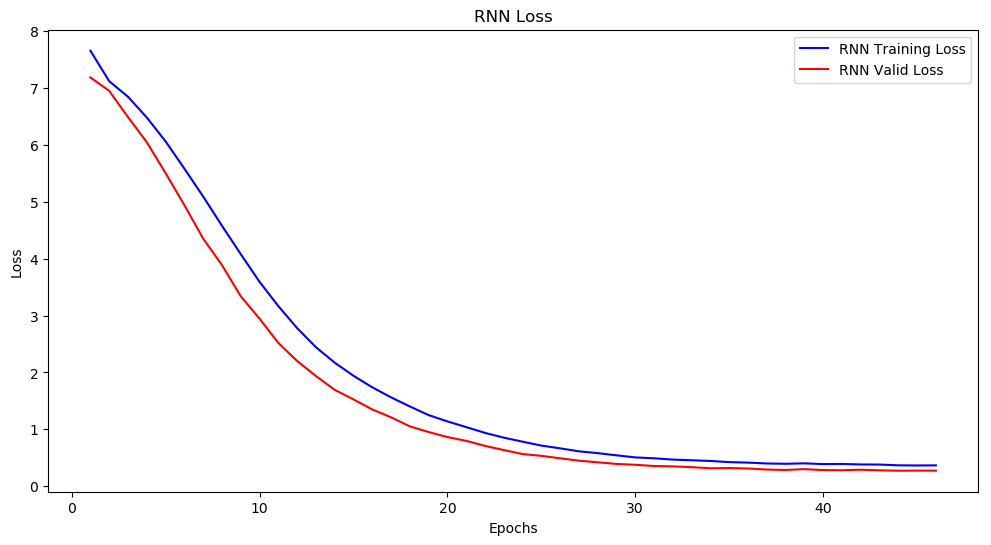

In [51]:
epochs = range(1, len(loss_RNN) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_RNN, 'b', label='RNN Training Loss')
plt.plot(epochs, val_loss_RNN, 'r', label='RNN Valid Loss')
plt.title('RNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

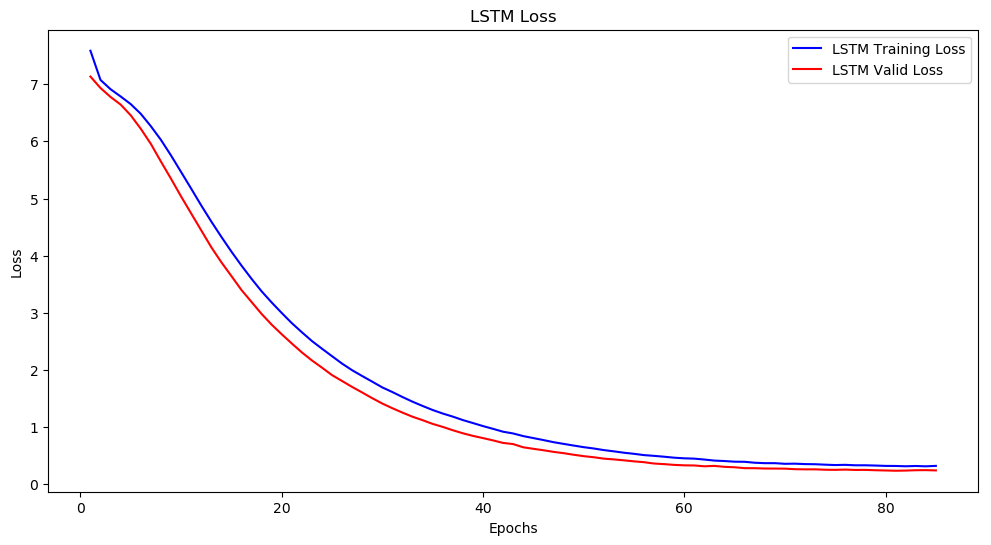

In [54]:
epochs = range(1, len(loss_LSTM) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_LSTM, 'b', label='LSTM Training Loss')
plt.plot(epochs, val_loss_LSTM, 'r', label='LSTM Valid Loss')
plt.title('LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

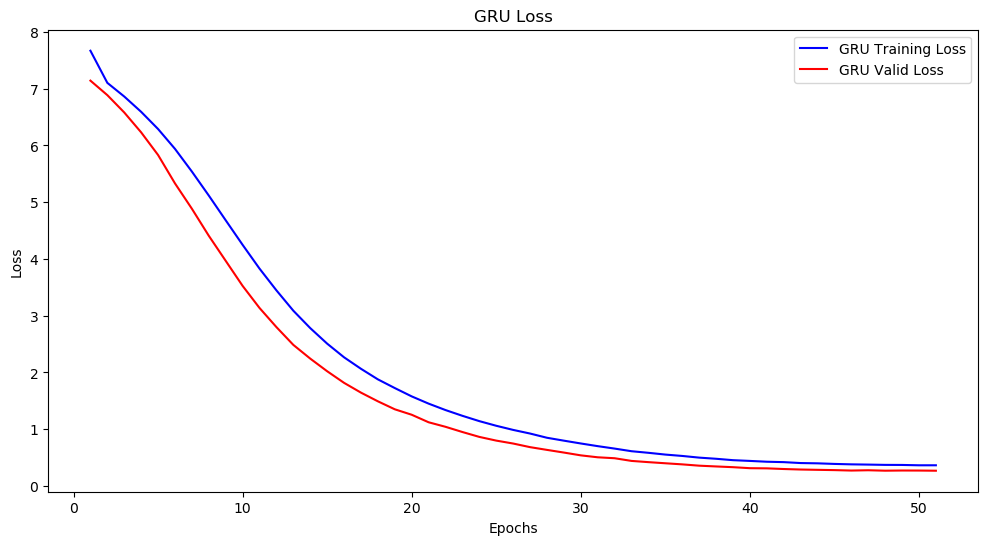

In [55]:
epochs = range(1, len(loss_GRU) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_GRU, 'b', label='GRU Training Loss')
plt.plot(epochs, val_loss_GRU, 'r', label='GRU Valid Loss')
plt.title('GRU Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
test_loss_RNN = model_RNN.evaluate(X_test, y_test)
test_loss_LSTM = model_LSTM.evaluate(X_test, y_test)
test_loss_GRU = model_GRU.evaluate(X_test, y_test)

1209/1209 [==============================] - 2s 1ms/sample - loss: 0.3379


## Generating the text

In [57]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [59]:
print('RNN')
print (generate_text("jack ", 5, model_RNN, max_sequence_len))
print('\n')
print('LSTM')
print (generate_text("jack ", 5, model_LSTM, max_sequence_len))
print('\n')
print('GRU')
print (generate_text("jack ", 5, model_RNN, max_sequence_len))

RNN
Jack  You Cant Put Frederick Douglass


LSTM
Jack  Concerns Rebels Backed By Turkey


GRU
Jack  You Cant Put Frederick Douglass


In [60]:
print('RNN')
print (generate_text("president trump", 5, model_RNN, max_sequence_len))
print('\n')
print('LSTM')
print (generate_text("president trump", 5, model_LSTM, max_sequence_len))
print('\n')
print('GRU')
print (generate_text("president trump", 5, model_RNN, max_sequence_len))

RNN
President Trump Tv Commentator As His Economic


LSTM
President Trump Scrambles To Cancel Dining Set


GRU
President Trump Tv Commentator As His Economic


In [61]:
print('RNN')
print (generate_text("india and china", 5, model_RNN, max_sequence_len))
print('\n')
print('LSTM')
print (generate_text("india and china", 5, model_LSTM, max_sequence_len))
print('\n')
print('GRU')
print (generate_text("india and china", 5, model_RNN, max_sequence_len))

RNN
India And China Levine And Learning To Cuomo


LSTM
India And China And A Pro To Get


GRU
India And China Levine And Learning To Cuomo


In [62]:
print('RNN')
print (generate_text("science and technology", 5, model_RNN, max_sequence_len))
print('\n')
print('LSTM')
print (generate_text("science and technology", 5, model_LSTM, max_sequence_len))
print('\n')
print('GRU')
print (generate_text("science and technology", 5, model_RNN, max_sequence_len))

RNN
Science And Technology Loss In Russia Trial Of


LSTM
Science And Technology Right Next Door To Help


GRU
Science And Technology Loss In Russia Trial Of
